In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [113]:
# clean speech
cl, fs = wavread("sound/NOIZEUS/clean/sp01.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
# wavwrite(ns, "sound/mixed/white_speech.wav")
ns, fs = wavread("sound/AIDA/training/sp11_train_sn0.wav")

([0.07116916409802546; 0.003173924985503708; … ; 0.011932737205114903; 9.155552842799158e-5], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [120]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_ar.jl")
cl_seg = get_frames(cl, fs)
ns_seg = get_frames(ns, fs)
totseg = size(ns_seg, 1)

391

In [212]:
include("models/everything.jl")

lar_inference_ex (generic function with 1 method)

In [213]:
ar_order = 10
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [214]:
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(ns_seg[segnum, :], ar_order)
    γ, τ, θ, x, fe = lar_inference_ex(outputs, ar_order, vmp_iter)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_ar[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(outputs, vmp_iter)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:53


In [215]:
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))]

391-element Vector{Bool}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0

In [216]:
rsegs = findall(isequal(1), vad)
nsegs = findall(isequal(0), vad)

28-element Vector{Int64}:
 206
 241
 242
 243
 247
 248
 250
 251
 252
 253
 256
 257
 258
   ⋮
 262
 263
 264
 266
 267
 269
 319
 342
 343
 344
 345
 391

In [217]:
rseg = rand(rsegs)
nseg = rand(nsegs)
println("$(rseg), $(nseg)")

78, 243


In [223]:
inv(var(sum([ns_seg[nseg, :] for nseg in nsegs])))

29.83488789970058

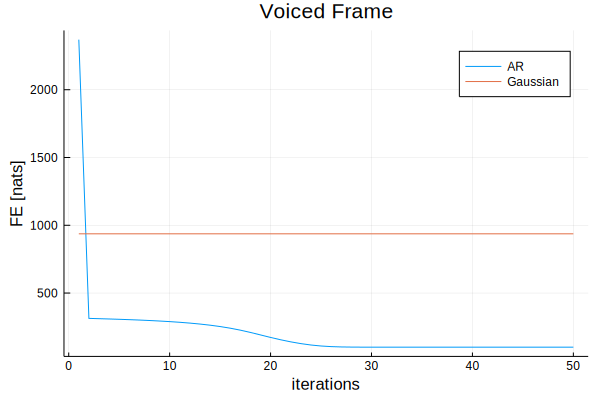

In [206]:
plot(fe_ar[rseg, :], label="AR")
plot!(fe_gaussian[rseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Voiced Frame")

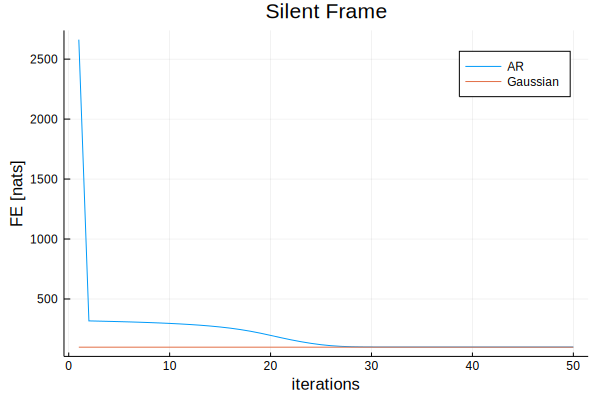

In [207]:
plot(fe_ar[nseg, :], label="AR")
plot!(fe_gaussian[nseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Silent Frame")

In [208]:
println("$(fe_gaussian[rseg, :][end]), $(fe_ar[rseg, :][end])")

936.986859006365, 100.67454985055474


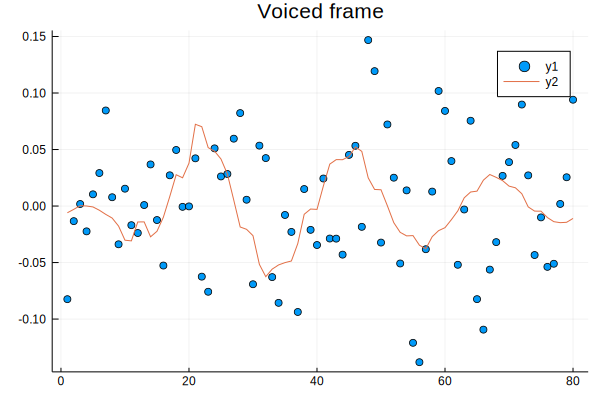

In [209]:
scatter(ns_seg[rseg, :])
plot!(cl_seg[rseg, :], title="Voiced frame")

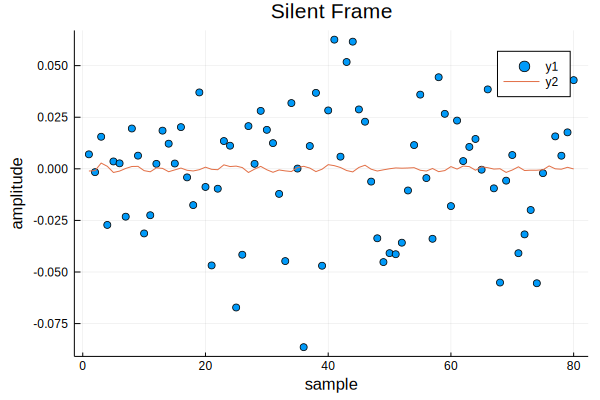

In [210]:
scatter(ns_seg[nseg, :])
plot!(cl_seg[nseg, :], ylabel="amplitude", xlabel="sample", title="Silent Frame")

In [211]:
include("helpers/aida_segmentation.jl")
check = get_signal(hcat([ns_seg[nseg, :] for nseg in nsegs]...)', 8000)
using WAV
wavwrite(check, fs, "/Users/apodusenko/Desktop/check.wav")